# Discovering Main Feature Differences Across Dosages

**Gregory Way, 2019**

## Batch 1 and 2

We apply a two tailed t-test to test for differences between features in the 0.7 and 7 doses considering only the resistant clones.

## Batch 3

Apply a two tailed t-test for differences between wildtype and resistant clones.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(cowplot))

In [2]:
viz_file <- file.path("scripts", "visualization_utils.R")
source(viz_file)

util_file <- file.path("scripts", "processing_utils.R")
source(util_file)

## Part 1 - Batch 1 and 2

In [3]:
doses <- c(0.7, 7)

axis_title_size <- 10
axis_text_size <- 9
strip_text_size <- 8
ggrepel_label_size <- 1.9
title_text_size <- 10
ymax <- 9

In [4]:
file <- file.path("data", "merged_intersected_variable_selected.csv")
data_df <- load_data(file)

print(dim(data_df))
head(data_df, 3)

[1] 72 66


Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_Batch_Number,Metadata_well_position,Metadata_CellLine,Metadata_Dosage,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_0,⋯,Nuclei_Granularity_8_DNA,Nuclei_Granularity_9_DNA,Nuclei_Location_MaxIntensity_Y_RNA,Nuclei_RadialDistribution_MeanFrac_Mito_1of4,Nuclei_RadialDistribution_RadialCV_AGP_1of4,Nuclei_RadialDistribution_RadialCV_AGP_2of4,Nuclei_RadialDistribution_RadialCV_ER_1of4,Nuclei_RadialDistribution_RadialCV_Mito_1of4,Nuclei_Texture_Correlation_RNA_10_01,Nuclei_Texture_Correlation_RNA_10_03
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HCT116bortezomib,B03,HCT116bortezomib,PlateMap_HCT116bortezomib,1,B03,WT,0,0.85727657,-0.3858899,⋯,-0.47024355,1.12160622,0.3762593,-1.759055,-0.68053556,-0.6446004,-0.5634461,-0.36363157,-1.43355903,-1.0812188
HCT116bortezomib,B04,HCT116bortezomib,PlateMap_HCT116bortezomib,1,B04,WT,0,0.68649109,0.5024000,⋯,-0.24886161,0.03721792,-0.5443365,-1.413942,-0.48795578,-0.6747323,-0.7727316,-0.22590011,-0.55055292,-0.5143410
HCT116bortezomib,B05,HCT116bortezomib,PlateMap_HCT116bortezomib,1,B05,WT,0,0.06455059,0.0033802,⋯,0.02263846,-0.38137450,-0.1406492,-1.343675,-0.09388887,-0.2848553,-0.6295427,-0.08707354,0.08001385,0.5337525


In [5]:
tstat_dose <- c()
pval_dose <- c()

tstat_cell <- c()
pval_cell <- c()

all_features <- c()
for (feature in colnames(data_df)) {
    if (!grepl("Metadata_", feature)) {
        # Perform Dose Experiment
        doseA <- data_df %>%
            dplyr::filter(Metadata_Dosage == doses[1],
                          Metadata_CellLine != "WT") %>%
            dplyr::pull(!!feature)
        
        doseB <- data_df %>%
            dplyr::filter(Metadata_Dosage == doses[2],
                          Metadata_CellLine != "WT") %>%
            dplyr::pull(!!feature)
        
        result <- t.test(doseA, doseB, var.equal = FALSE)
        
        tstat_dose <- c(tstat_dose, as.numeric(paste(result$statistic)))
        pval_dose <- c(pval_dose, result$p.value)
        
        # Perform Cell Line Experiment at 0.7uM Dose
        resistant_clones <- data_df %>%
            dplyr::filter(Metadata_Dosage == 0.7,
                          Metadata_CellLine != "WT") %>%
            dplyr::pull(!!feature)
        
        wt_cells <- data_df %>%
            dplyr::filter(Metadata_Dosage == 0.7,
                          Metadata_CellLine == "WT") %>%
            dplyr::pull(!!feature)
        
        result <- t.test(resistant_clones, wt_cells, var.equal = FALSE)
        
        tstat_cell <- c(tstat_cell, as.numeric(paste(result$statistic)))
        pval_cell <- c(pval_cell, result$p.value)
        
        # Track which feature is being tested
        all_features <- c(all_features, feature)
    }
}

In [6]:
# Obtain Results for Dose Differences
result_dose_df <- as.data.frame(cbind(tstat_dose, pval_dose))
result_dose_df$neglog10p <- -log10(result_dose_df$pval_dose)
result_dose_df$feature <- all_features
result_dose_df <- result_dose_df %>% dplyr::arrange(desc(neglog10p))

dim(result_dose_df)
head(result_dose_df, 3)

[1] 58  4

tstat_dose,pval_dose,neglog10p,feature
<dbl>,<dbl>,<dbl>,<chr>
-13.013356,1.874475e-09,8.727120,Nuclei_AreaShape_Zernike_6_2
7.118472,1.440664e-06,5.841437,Cytoplasm_AreaShape_Zernike_3_1
-7.019841,2.848861e-06,5.545329,Nuclei_AreaShape_MaxFeretDiameter


In [7]:
# Obtain Results for Cell Line Differences
result_cell_df <- as.data.frame(cbind(tstat_cell, pval_cell))
result_cell_df$neglog10p <- -log10(result_cell_df$pval_cell)
result_cell_df$feature <- all_features
result_cell_df <- result_cell_df %>% dplyr::arrange(desc(neglog10p))

dim(result_cell_df)
head(result_cell_df, 3)

[1] 58  4

tstat_cell,pval_cell,neglog10p,feature
<dbl>,<dbl>,<dbl>,<chr>
7.108817,9.967254e-06,5.001424,Cytoplasm_Granularity_2_Mito
5.776658,7.474418e-05,4.126423,Nuclei_RadialDistribution_RadialCV_AGP_1of4
5.776679,9.847155e-05,4.006689,Cytoplasm_AreaShape_Zernike_3_1


In [8]:
alpha_correction <- -log10(0.05 / dim(result_dose_df)[1])
repel_logic <- result_dose_df$neglog10p > alpha_correction * 1.5

ttest_dose_gg <- ttest_volcano(
    df = result_dose_df,
    x_string = "tstat_dose",
    title = "0.7nM vs. 7nM Dose (Resistant Clones)",
    title_text_size = title_text_size,
    yintercept = alpha_correction,
    repel_logic = repel_logic,
    ggrepel_label_size = ggrepel_label_size,
    axis_text_size = axis_text_size,
    axis_title_size = axis_title_size,
    ymax = ymax
)

In [9]:
alpha_correction <- -log10(0.05 / dim(result_cell_df)[1])
repel_logic <- result_cell_df$neglog10p > alpha_correction * 1.1

ttest_cell_gg <- ttest_volcano(
    df = result_cell_df,
    x_string = "tstat_cell",
    title = "Resistant vs. Wildtype Cells (0.7nM)",
    title_text_size = title_text_size,
    yintercept = alpha_correction,
    repel_logic = repel_logic,
    ggrepel_label_size = ggrepel_label_size,
    axis_text_size = axis_text_size,
    axis_title_size = axis_title_size,
    ymax = ymax
)

In [10]:
# The top feature is something to do with nuclear area
top_feature <- paste(result_dose_df$feature[1])

append_batch <- function(string) paste("Batch:", string)
append_dose <- function(string) paste0("Dose: ", string, "nM")

distrib_gg <- ggplot(data_df, aes_string(x = `top_feature`)) +
    geom_density(aes(fill = Metadata_CellLine),
                 alpha = 0.6) +
    geom_rug(aes(color = Metadata_CellLine),
             alpha = 0.8,
             size = 0.5) +
    facet_grid(Metadata_Dosage ~ Metadata_Batch_Number,
               scales = "fixed",
               labeller = labeller(Metadata_Batch_Number = as_labeller(append_batch),
                                   Metadata_Dosage = as_labeller(append_dose))) +
    scale_color_manual(name = "Cell Line",
                      labels = c("CloneA" = "Clone A",
                                 "CloneE" = "Clone E",
                                 "WT" = "Wild type"),
                      values = c("CloneA" = "#1b9e77",
                                 "CloneE" = "#d95f02",
                                 "WT" = "#7570b3")) +
    scale_fill_manual(name = "Cell Line",
                      labels = c("CloneA" = "Clone A",
                                 "CloneE" = "Clone E",
                                 "WT" = "Wild type"),
                      values = c("CloneA" = "#1b9e77",
                                 "CloneE" = "#d95f02",
                                 "WT" = "#7570b3")) +
    theme_bw() +
    theme(axis.text = element_text(size = axis_text_size),
          axis.title = element_text(size = axis_title_size),
          strip.text = element_text(size = strip_text_size),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

In [11]:
table(data_df$Metadata_CellLine,
      data_df$Metadata_Dosage,
      data_df$Metadata_Batch_Number)

, ,  = 1

        
         0 0.7 7 70
  CloneA 3   3 3  3
  CloneE 3   3 3  3
  WT     3   3 3  3

, ,  = 2

        
         0 0.7 7 70
  CloneA 3   3 3  3
  CloneE 3   3 3  3
  WT     3   3 3  3


### Combine Batch 1 and 2 Into Cowplot

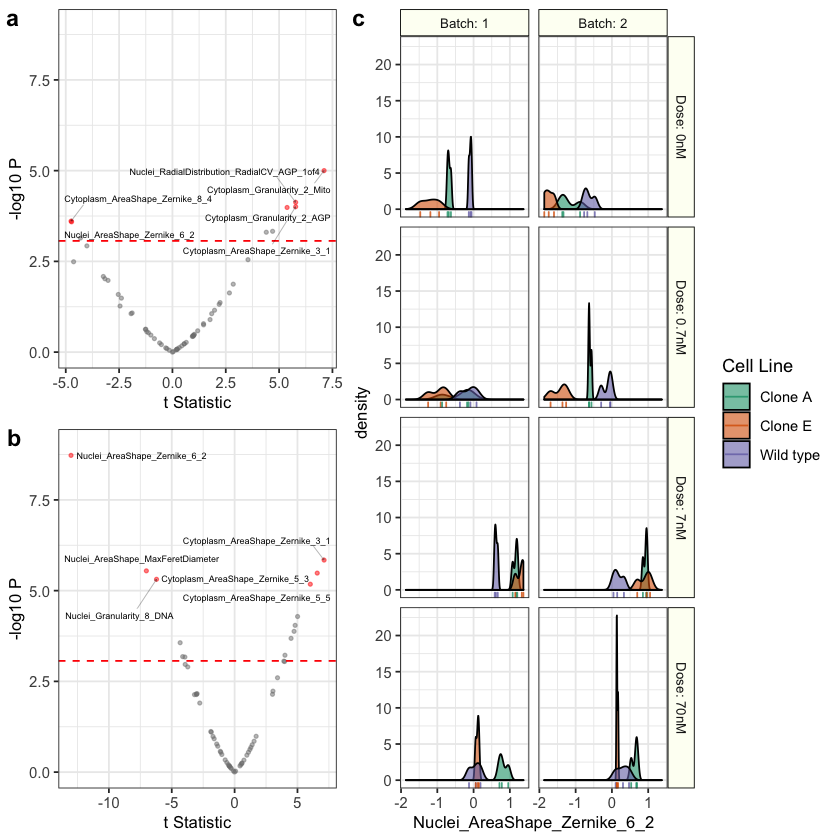

In [12]:
feature_plot <- (
    cowplot::plot_grid(
        ttest_cell_gg,
        ttest_dose_gg,
        labels = c("a", "b"),
        ncol = 1,
        nrow = 2
    )
)

main_plot <- (
    cowplot::plot_grid(
        feature_plot,
        distrib_gg,
        labels = c("", "c"),
        ncol = 2,
        nrow = 1,
        rel_widths = c(0.7, 1)
    )
)

main_plot

In [13]:
file_base <- file.path("figures", "dosage_feature_figure")
save_figure(main_plot, file_base, height = 6, width = 8)

## Part 2 - Batch 3

In [14]:
batch <- "2019_06_25_Batch3"
file <- file.path("data", paste0(batch, "_merged_intersected_variable_selected.csv"))

data_df <- load_data(file)

print(dim(data_df))
head(data_df, 3)

[1] 105 191


Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,⋯,Nuclei_Texture_Correlation_AGP_20_00,Nuclei_Texture_Correlation_AGP_20_03,Nuclei_Texture_Correlation_AGP_5_00,Nuclei_Texture_Correlation_ER_20_02,Nuclei_Texture_Correlation_Mito_5_00,Nuclei_Texture_Correlation_RNA_20_02,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_AGP_20_02,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_InverseDifferenceMoment_ER_20_02
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MutClones,B02,MutClones,MutClones,B02,BZ001,0.6034418,-3.057030,0.05068862,0.6585738,⋯,3.3582920,1.126295,0.000000,1.204256,0.42066821,0.5705776,-1.320394,-0.2247533,1.311671,0.212493
MutClones,B03,MutClones,MutClones,B03,BZ002,-1.0295421,-1.419110,1.11426953,-0.9345095,⋯,-0.3068762,1.536572,-4.293160,3.379792,-6.81572415,0.4181798,3.899485,2.1667509,2.502230,2.646517
MutClones,B04,MutClones,MutClones,B04,BZ003,1.6599068,-1.161031,-1.71337361,-0.2834930,⋯,4.4402692,1.169331,2.445327,4.378964,0.08634202,0.9786170,-2.408064,-0.1248563,0.000000,1.157526


In [15]:
tstat_cell <- c()
pval_cell <- c()

all_features <- c()
for (feature in colnames(data_df)) {
    if (!grepl("Metadata_", feature)) {
        
        # Perform Cell Line Experiment at 0.7uM Dose
        resistant_clones <- data_df %>%
            dplyr::filter(Metadata_Plate == "MutClones") %>%
            dplyr::pull(!!feature)
        
        wt_cells <- data_df %>%
            dplyr::filter(Metadata_Plate == "WTClones") %>%
            dplyr::pull(!!feature)
        
        result <- t.test(resistant_clones, wt_cells, var.equal = FALSE)
        
        tstat_cell <- c(tstat_cell, as.numeric(paste(result$statistic)))
        pval_cell <- c(pval_cell, result$p.value)
        
        # Track which feature is being tested
        all_features <- c(all_features, feature)
    }
}

In [16]:
# Obtain Results for Cell Line Differences
result_cell_df <- as.data.frame(cbind(tstat_cell, pval_cell))
result_cell_df$neglog10p <- -log10(result_cell_df$pval_cell)
result_cell_df$feature <- all_features
result_cell_df <- result_cell_df %>% dplyr::arrange(desc(neglog10p))

dim(result_cell_df)
head(result_cell_df, 3)

[1] 185   4

tstat_cell,pval_cell,neglog10p,feature
<dbl>,<dbl>,<dbl>,<chr>
4.020517,0.0001114385,3.952965,Nuclei_AreaShape_Zernike_4_4
2.781833,0.0064406761,2.191069,Nuclei_AreaShape_Zernike_8_6
2.746650,0.0076908558,2.114025,Nuclei_Texture_AngularSecondMoment_DNA_5_03


In [17]:
alpha_correction <- -log10(0.05 / dim(result_cell_df)[1])
repel_logic <- (
    result_cell_df$neglog10p > alpha_correction | 
    result_cell_df$tstat_cell > 2.65 |
    result_cell_df$tstat_cell < -2.4
    )

ttest_cell_gg <- ttest_volcano(
    df = result_cell_df,
    x_string = "tstat_cell",
    title = "Resistant vs. Wildtype Cells",
    title_text_size = title_text_size,
    yintercept = alpha_correction,
    repel_logic = repel_logic,
    ggrepel_label_size = ggrepel_label_size,
    axis_text_size = axis_text_size,
    axis_title_size = axis_title_size,
    ymax = ymax
)

In [18]:
# The top feature is something to do with nuclear area
top_feature <- paste(result_cell_df$feature[1])

distrib_gg <- ggplot(data_df,
                     aes_string(x = `top_feature`)) +
    geom_density(aes(fill = Metadata_Plate_Map_Name),
                 alpha = 0.6) +
    geom_rug(aes(color = Metadata_Plate_Map_Name),
             alpha = 0.8,
             size = 0.5) +
    scale_color_manual(name = "Cell Line",
                      labels = c("MutClones" = "Mutant",
                                 "WTClones" = "Wild-type"),
                      values = c("MutClones" = "#1b9e77",
                                 "WTClones" = "#d95f02")) +
    scale_fill_manual(name = "Cell Line",
                      labels = c("MutClones" = "Mutant",
                                 "WTClones" = "Wild-type"),
                      values = c("MutClones" = "#1b9e77",
                                 "WTClones" = "#d95f02")) +
    theme_bw() +
    theme(axis.text = element_text(size = axis_text_size),
          axis.title = element_text(size = axis_title_size),
          strip.text = element_text(size = strip_text_size),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

In [19]:
top_neg <- result_cell_df %>%
    dplyr::arrange(tstat_cell) %>%
    select(feature)

top_feature = top_neg$feature[1]

distrib_neg_gg <- ggplot(data_df,
                         aes_string(x = `top_feature`)) +
    geom_density(aes(fill = Metadata_Plate_Map_Name),
                 alpha = 0.6) +
    geom_rug(aes(color = Metadata_Plate_Map_Name),
             alpha = 0.8,
             size = 0.5) +
    scale_color_manual(name = "Cell Line",
                      labels = c("MutClones" = "Mutant",
                                 "WTClones" = "Wild-type"),
                      values = c("MutClones" = "#1b9e77",
                                 "WTClones" = "#d95f02")) +
    scale_fill_manual(name = "Cell Line",
                      labels = c("MutClones" = "Mutant",
                                 "WTClones" = "Wild-type"),
                      values = c("MutClones" = "#1b9e77",
                                 "WTClones" = "#d95f02")) +
    theme_bw() +
    theme(axis.text = element_text(size = axis_text_size),
          axis.title = element_text(size = axis_title_size),
          strip.text = element_text(size = strip_text_size),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

### Combine Plots into Cowplot

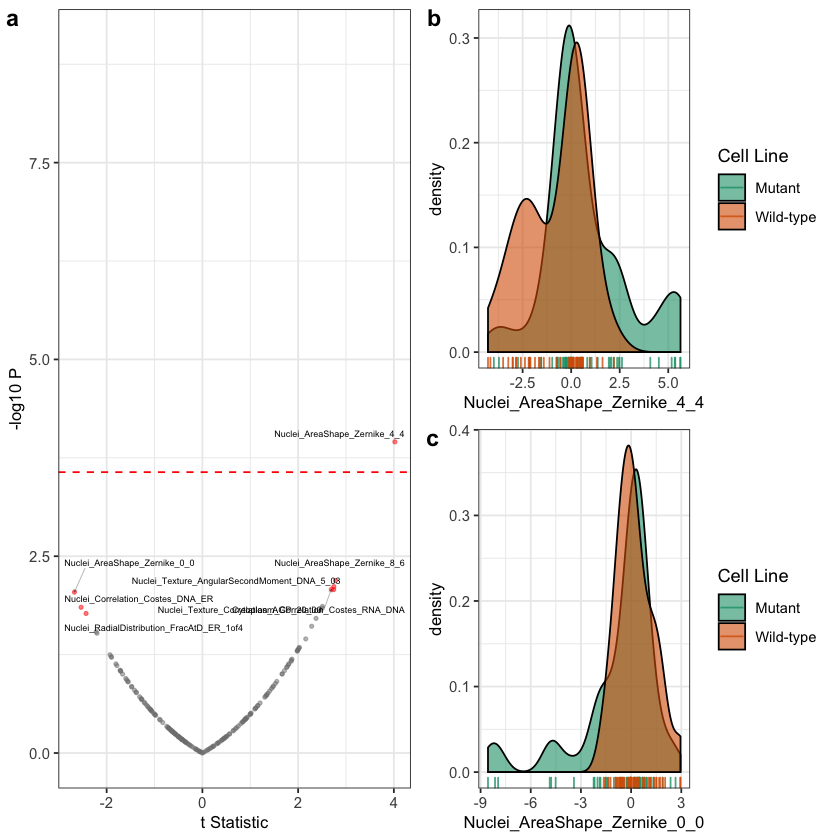

In [20]:
full_distrib_gg <- (
    cowplot::plot_grid(
        distrib_gg,
        distrib_neg_gg,
        labels = c("b", "c"),
        nrow = 2
    )
)

main_plot <- (
    cowplot::plot_grid(
        ttest_cell_gg,
        full_distrib_gg,
        labels = c("a", ""),
        ncol = 2,
        nrow = 1,
        rel_widths = c(1, 1)
    )
)

main_plot

In [21]:
file_base <- file.path("figures", paste0(batch, "_feature_figure"))
save_figure(main_plot, file_base, height = 6, width = 8.5)